In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string
import unicodedata
from rake_nltk import Rake
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

movies_df = pd.read_csv('../data/similarity_model_dataset.csv')# Get user input description

example_user_input = "In this thrilling fantasy film, a young wizard competes in a dangerous tournament between rival schools of magic. Along with his friends, he navigates challenging tasks and uncovers a dark conspiracy that threatens the entire wizarding world. With impressive special effects and a talented cast, this captivating adventure is full of action, humor, and heart."


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xaviersantos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xaviersantos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/xaviersantos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xaviersantos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def remove_accents(sentence):
    cleaned_sentence = unicodedata.normalize('NFD', sentence)
    cleaned_sentence = cleaned_sentence.encode('ascii', 'ignore')
    cleaned_sentence = cleaned_sentence.decode("utf-8")
    return cleaned_sentence

def remove_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    cleaned_sentence = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace("\n"," ")
    return cleaned_sentence

def keep_alpha(sentence):
    alpha_sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    return alpha_sentence

def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence=' '.join(stemmed_words)
    return stemmed_sentence

def lemmatize_words(sentence):
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, 'v') for word in sentence.split()]
    lemmatized_sentence=' '.join(lemmatized_words)
    return lemmatized_sentence

def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                       'may','also','across','among','beside','however','yet','within','find'])
    no_stop_words=[word for word in sentence.split() if word not in stop_words]
    no_step_sentence = ' '.join(no_stop_words)
    return no_step_sentence

def lower_case(sentence):
    lower_case_sentence = sentence.lower()
    return lower_case_sentence

def tokenize_input(sentence):
    pre_processed_sentence = remove_accents(sentence)
    pre_processed_sentence = remove_punctuation(pre_processed_sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    return pre_processed_sentence

def get_movies_ranked_bow(user_input, movies_df):
    vectorizer = CountVectorizer()
    movie_bow = vectorizer.fit_transform(movies_df['Description Tokenized'])
    tokenized_user_input = tokenize_input(user_input)
    tokenized_user_input = RegexpTokenizer(r'[a-zA-z]+').tokenize(tokenized_user_input)
    user_input_bow = vectorizer.transform(tokenized_user_input)
    similarity_scores = cosine_similarity(user_input_bow, movie_bow)
    movies_df = movies_df.assign(similarity=similarity_scores[0])
    return movies_df.sort_values('similarity', ascending=False).reset_index(drop=True)


In [3]:
def get_movies_ranked_tfidf(user_input, movies_df):
    vectorizer = TfidfVectorizer()   
    tokenized_user_input = tokenize_input(user_input)
    tokenized_user_input = RegexpTokenizer(r'[a-zA-z]+').tokenize(tokenized_user_input)
    tfidf_bow = vectorizer.fit_transform(movies_df['Description Tokenized'])
    user_input_tfidf_bow = vectorizer.transform(tokenized_user_input)
    tfidf_scores = cosine_similarity(user_input_tfidf_bow, tfidf_bow)
    movies_df = movies_df.assign(similarity=tfidf_scores[0])
    return movies_df.sort_values('similarity', ascending=False).reset_index(drop=True)
    


In [4]:
def get_similar_movies(user_input, r, vectorizer, tfidf_matrix, n=10):
    keywords = r.extract_keywords_from_text(user_input)
    user_input_keywords = r.get_ranked_phrases()
    user_input_tfidf = vectorizer.transform(user_input_keywords)
    return cosine_similarity(user_input_tfidf, tfidf_matrix)
    

def get_movies_ranked_rake(user_input, movies_df):
    r = Rake()
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(movies_df['Description Tokenized'])
    cosine_similarities = get_similar_movies(user_input, r, vectorizer, tfidf_matrix)
    movies_df = movies_df.assign(similarity=cosine_similarities[0])
    return movies_df.sort_values('similarity', ascending=False).reset_index(drop=True)


In [5]:
test_cases = [
    ("The fourth movie in the Harry Potter franchise sees Harry returning for his fourth year at Hogwarts School of Witchcraft and Wizardry, along with his friends, Ron (Rupert Grint) and Hermione (Emma Watson). There is an upcoming tournament between the three major schools of magic, with one participant selected from each school by the Goblet of Fire. When Harry's name is drawn, even though he is not eligible and is a fourth player, he must compete in the dangerous contest.", "Harry Potter and the Goblet of Fire"),
    ("When a group of terrorists take over the Nakatomi Plaza in Los Angeles, New York City police officer John McClane (Bruce Willis) must use his cunning and fighting skills to take down the villains and save the hostages, including his estranged wife.", "Die Hard"),
    ("In a post-apocalyptic world, Katniss Everdeen (Jennifer Lawrence) volunteers to compete in the annual Hunger Games, a televised fight to the death between children from each of the twelve districts of Panem. With the help of fellow tribute Peeta Mellark (Josh Hutcherson), Katniss must fight for survival and challenge the oppressive government.", "The Hunger Games"),
    ("In the world of professional street racing, Dominic Toretto (Vin Diesel) and his crew must work together to take down a common enemy, a dangerous drug lord named Arturo Braga. With high-speed chases and intense action, the stakes have never been higher for Dom and his team.", "Fast & Furious"),
    ("A brilliant scientist, Dr. Bruce Banner (Edward Norton) must confront his inner demons and fight against the military and his own alter ego, the Hulk. With the help of his love interest Betty Ross (Liv Tyler), Bruce must find a way to control the monster within and stop a dangerous villain from exploiting his power.", "The Incredible Hulk"),
    ("In 1942, a group of Allied soldiers are stranded in Nazi-occupied France and must carry out a dangerous mission to take down a German radio tower. Led by Captain John H. Miller (Tom Hanks), the team faces overwhelming odds and must rely on their courage and camaraderie to succeed.", "Saving Private Ryan")]


In [6]:
def get_similarity(test_case, algorithm, movies_df):
    description, expected_movie = test_case
    movies_df = algorithm(description, movies_df)
    expected_row = movies_df.loc[movies_df['Name'] == expected_movie]
    similarity = expected_row['similarity'].values[0]
    index = expected_row.index[0] + 1
    return similarity, index


In [7]:
test_cases = [
    ("The fourth movie in the Harry Potter franchise sees Harry returning for his fourth year at Hogwarts School of Witchcraft and Wizardry, along with his friends, Ron (Rupert Grint) and Hermione (Emma Watson). There is an upcoming tournament between the three major schools of magic, with one participant selected from each school by the Goblet of Fire. When Harry's name is drawn, even though he is not eligible and is a fourth player, he must compete in the dangerous contest.", "Harry Potter and the Goblet of Fire"),
    ("When a group of terrorists take over the Nakatomi Plaza in Los Angeles, New York City police officer John McClane (Bruce Willis) must use his cunning and fighting skills to take down the villains and save the hostages, including his estranged wife.", "Die Hard with a Vengeance"),
    ("Lion prince Simba and his father are targeted by his bitter uncle, who wants to ascend the throne himself.", "The Lion King"),
    ("In a post-apocalyptic world, Katniss Everdeen (Jennifer Lawrence) volunteers to compete in the annual Hunger Games, a televised fight to the death between children from each of the twelve districts of Panem. With the help of fellow tribute Peeta Mellark (Josh Hutcherson), Katniss must fight for survival and challenge the oppressive government.", "The Hunger Games"),
    ("A brilliant scientist, Dr. Bruce Banner (Edward Norton) must confront his inner demons and fight against the military and his own alter ego, the Hulk. With the help of his love interest Betty Ross (Liv Tyler), Bruce must find a way to control the monster within and stop a dangerous villain from exploiting his power.", "The Incredible Hulk"),
    ("In 1942, a group of Allied soldiers are stranded in Nazi-occupied France and must carry out a dangerous mission to take down a German radio tower. Led by Captain John H. Miller (Tom Hanks), the team faces overwhelming odds and must rely on their courage and camaraderie to succeed.", "Saving Private Ryan"),
    ("A gunslinger (Antonio Banderas) seeks revenge on the drug lord (Joaquim de Almeida) who killed his lover in this action-packed western.", "Desperado"),
    ("The long-awaited sequel to Avatar finds Jake Sully (Sam Worthington) and Neytiri (Zoe Saldana) returning to the magical world of Pandora, where they must fight to protect their people and their planet from new threats.", "Avatar: The Way of Water"),
    ("Rocky Balboa proudly holds the world heavyweight boxing championship, but a new challenger has stepped forward: Drago, a six-foot-four, 261-pound fighter who has the backing of the Soviet Union.", "Rocky IV"),
]


Harry Potter and the Goblet of Fire RAKE : Index -> 1 Similarity Score ->0.3689237685754112
Harry Potter and the Goblet of Fire TF-IDF : Index -> 321 Similarity Score ->0.0
Harry Potter and the Goblet of Fire BOW : Index -> 321 Similarity Score ->0.0
Die Hard with a Vengeance RAKE : Index -> 1 Similarity Score ->0.43482454400909937
Die Hard with a Vengeance TF-IDF : Index -> 6890 Similarity Score ->0.0
Die Hard with a Vengeance BOW : Index -> 6890 Similarity Score ->0.0
The Lion King RAKE : Index -> 1 Similarity Score ->0.6106065216967139
The Lion King TF-IDF : Index -> 2 Similarity Score ->0.3526650577800436
The Lion King BOW : Index -> 2 Similarity Score ->0.31622776601683794
The Hunger Games RAKE : Index -> 3 Similarity Score ->0.24252954029392265
The Hunger Games TF-IDF : Index -> 5182 Similarity Score ->0.0
The Hunger Games BOW : Index -> 5182 Similarity Score ->0.0
The Incredible Hulk RAKE : Index -> 1 Similarity Score ->0.286189036585167
The Incredible Hulk TF-IDF : Index -> 396

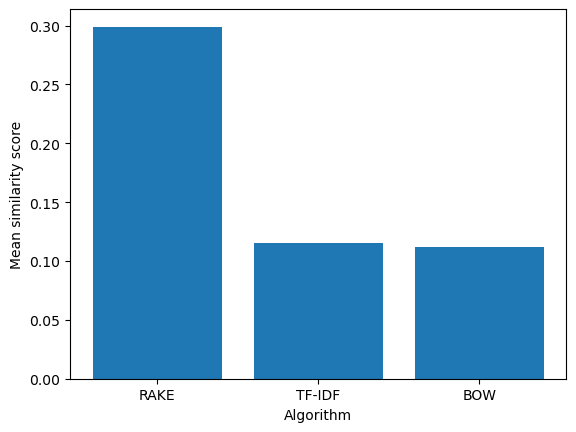

In [8]:
algorithms = [get_movies_ranked_rake, get_movies_ranked_tfidf, get_movies_ranked_bow]
algorithm_names = ['RAKE', 'TF-IDF', 'BOW']

results = np.zeros((len(test_cases), len(algorithms)))

for i, test_case in enumerate(test_cases):
    for j, algorithm in enumerate(algorithms):
        similarity, index = get_similarity(test_case, algorithm, movies_df)
        print(test_case[1] + " " + algorithm_names[j] + " : Index -> " + str(index) + " Similarity Score ->" + str(similarity))
        results[i,j] = similarity

mean_similarities = results.mean(axis=0)

import matplotlib.pyplot as plt

plt.bar(algorithm_names, mean_similarities)
plt.xlabel('Algorithm')
plt.ylabel('Mean similarity score')
plt.show()